In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

import numpy as np

import torch
from tqdm.auto import tqdm

import maze
import env_utils
from functools import partial
import goexplore_discrete
from torch import nn
from mzr_old import layer_init

In [3]:
import maze_run
from maze_run import make_single_env, make_env, MazeEnv

In [3]:
np.random.seed(0)
height, width = 71, 71
grids = np.stack([maze.generate_maze(height, width) for i in tqdm(range(1000))])

100%|██████████| 1000/1000 [13:34<00:00,  1.23it/s]


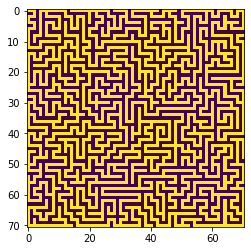

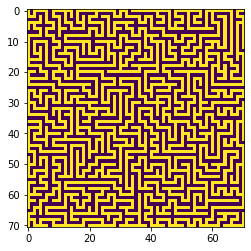

In [5]:
plt.imshow(grids[0])
plt.show()
plt.imshow(grids[1])
plt.show()

In [ ]:
env = make_env(100, 4)
ge = goexplore_discrete.GoExplore(env)
for i in tqdm(range(100)):
    nodes = ge.select_nodes(100, beta=-2.)
    ge.explore_from(nodes, 15)

/Users/akarshkumar0101/miniconda3/lib/python3.9/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/akarshkumar0101/miniconda3/lib/python3.9/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
 10%|█         | 1/10 [00:37<05:37, 37.55s/it]


KeyboardInterrupt: 

In [35]:
ges = torch.load('data/ges.pt')

In [36]:
ge = ges[8]

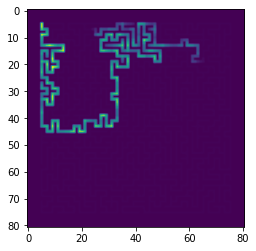

In [37]:
grid = ge.env.envs[0].grid.copy()
cells = list(ge.cell2n_seen.keys())
n_seen = list(ge.cell2n_seen.values())
for i in range(len(cells)):
    y, x = cells[i]
    grid[y, x] = n_seen[i]
plt.imshow(grid)

In [118]:
def get_dataset(ges, n_nodes=10):
    o, a = [], []
    for seed, ge in enumerate(tqdm(ges)):
        nodes = ge.select_nodes(n_nodes, beta=-0.5)
        # print(len(nodes))
        # print(len(set([node.cell for node in nodes])))
        e = ge.env.envs[0]
        e.seed(seed)
        for node in nodes:
            obs, info = e.reset()
            for action in node.snapshot:
                o.append(obs)
                a.append(action)
                obs, reward, terminated, truncated, info = e.step(action)
    return np.stack(o), np.asarray(a)
o, a = get_dataset(ges, 10)

100%|██████████| 10/10 [00:00<00:00, 10.42it/s]


In [119]:
o.shape, a.shape

((33506, 4, 11, 11), (33506,))

In [120]:
class ImitationExplorer(nn.Module):
    def __init__(self, envs, num_frames=4):
        super().__init__()
        self.encoder = nn.Sequential(
            layer_init(nn.Conv2d(num_frames, 16, 3, stride=1)),
            nn.ReLU(),
            layer_init(nn.Conv2d(16, 32, 3, stride=1)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 3, stride=1)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 3 * 3, 512)),
            nn.ReLU(),
        )
        self.actor = layer_init(nn.Linear(512, envs.single_action_space.n), std=0.01)
        self.critic = layer_init(nn.Linear(512, 1), std=1)

    def forward(self, x):
        return self.get_dist_and_values(x)

    def get_dist_and_values(self, x):
        """
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        """
        x = self.encoder(x)
        logits, values = self.actor(x), self.critic(x)
        dist = torch.distributions.Categorical(logits=logits)
        return dist, values[:, 0]

    def act(self, x):
        dist, _ = self.get_dist_and_values(x)
        return dist.sample()

agent = ImitationExplorer(ge.env)

In [128]:

def bc_agent(o, a, agent, batch_size=32, n_batches=10, lr=1e-3, device=None):
    loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
    opt = torch.optim.Adam(agent.parameters(), lr=lr)
    pbar = tqdm(range(n_batches))
    for i in pbar:
        idx_batch = torch.randperm(len(o))[:batch_size]
        x_batch, y_batch = o[idx_batch], a[idx_batch]
        x_batch, y_batch = torch.from_numpy(x_batch).float().to(device), torch.from_numpy(y_batch).long().to(device)
        dist, values = agent(x_batch)
        loss = loss_fn(dist.logits, y_batch).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
        pbar.set_postfix(loss=loss.item())

agent = ImitationExplorer(ge.env)
bc_agent(o, a, agent, batch_size=512, n_batches=1000)

100%|██████████| 1000/1000 [00:45<00:00, 21.89it/s, loss=0.523]


In [137]:
np.random.seed(10032)
grid = maze.generate_maze(71, 71)

env_eval = maze_run.make_env(grid[None], 1, 4)

In [168]:
video = []
obs, info = env_eval.reset()
for i in tqdm(range(100)):
    video.append(obs[-1])
    obs, reward, terminated, truncated, info = env_eval.step(agent.act(obs))
video = np.concatenate(video, axis=0)

100%|██████████| 100/100 [00:00<00:00, 897.57it/s]


0


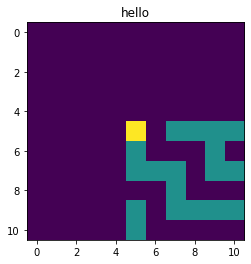

40


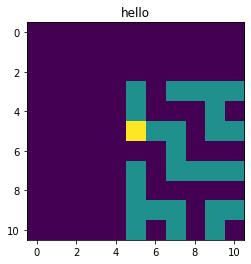

80


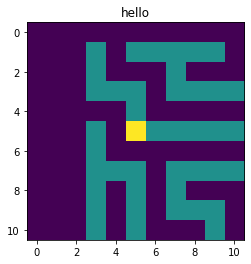

120


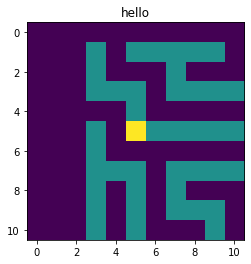

160


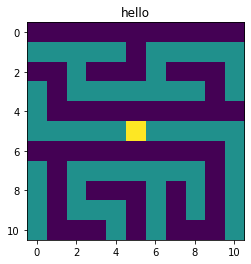

200


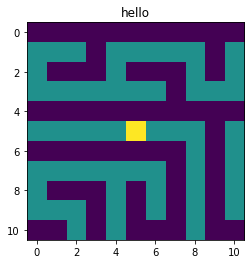

240


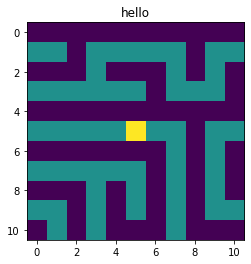

280


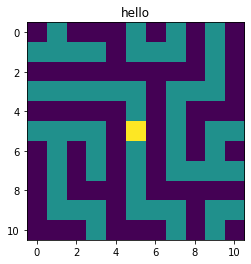

320


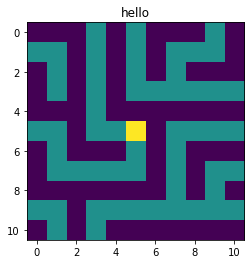

360


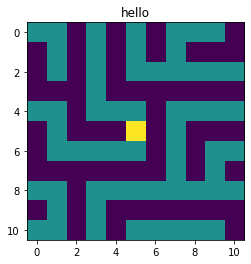

In [171]:
for i in range(0, len(video), 40):
    print(i)
    plt.imshow(video[i])
    plt.show()

In [ ]:
nodes = ge.select_nodes(100, beta=-10.)
cells = [node.cell for node in nodes]

In [37]:
def prim(row_count, col_count):
    """Creates a maze using Prim's algorithm."""
    maze = np.zeros((2 * row_count + 1, 2 * col_count + 1, 3), dtype=np.uint8)

    row_count_with_walls = maze.shape[0]
    col_count_with_walls = maze.shape[1]
    row_count = row_count_with_walls // 2
    col_count_with_walls = col_count_with_walls // 2
    def _out_of_bounds(x, y):
        return x < 0 or y < 0 or x >= row_count_with_walls or y >= col_count_with_walls
    _dir_one = [
        lambda x, y: (x + 1, y),
        lambda x, y: (x - 1, y),
        lambda x, y: (x, y - 1),
        lambda x, y: (x, y + 1)
    ]
    _dir_two = [
        lambda x, y: (x + 2, y),
        lambda x, y: (x - 2, y),
        lambda x, y: (x, y - 2),
        lambda x, y: (x, y + 2)
    ]
    _range = list(range(4))
    def _random():
        """Returns a random range to iterate over."""
        np.random.shuffle(_range)
        return _range

    frontier = []  # List of unvisited cells [(x, y),...]

    # Start with random cell
    x = 2 * np.random.randint(0, row_count - 1) + 1
    y = 2 * np.random.randint(0, col_count - 1) + 1
    maze[x, y] = [255, 255, 255]  # Mark as visited

    # Add cells to frontier for random cell
    for direction in _dir_two:
        tx, ty = direction(x, y)
        if not _out_of_bounds(tx, ty):
            frontier.append((tx, ty))
            maze[tx, ty, 0] = 1  # Mark as part of frontier

    print(len(frontier))
    # Add and connect cells until frontier is empty
    while frontier:
        print(len(frontier))
        x, y = frontier.pop(np.random.randint(0, len(frontier) - 1))

        # Connect cells
        for idx in _random():
            tx, ty = _dir_two[idx](x, y)
            if not _out_of_bounds(tx, ty) and maze[tx, ty, 0] == 255:  # Check if visited
                maze[x, y] = maze[_dir_one[idx](x, y)] = [255, 255, 255]  # Connect cells
                break

        # Add cells to frontier
        for direction in _dir_two:
            tx, ty = direction(x, y)
            if not _out_of_bounds(tx, ty) and maze[tx, ty, 0] == 0:  # Check if unvisited
                frontier.append((tx, ty))
                maze[tx, ty, 0] = 1  # Mark as part of frontier
    return maze

In [38]:
grid = prim(25, 25)

4
4
6
7
8
9
10
11
13
14
14
15
16
16
16
17
17
17
17
19
20
20
21
20
19
19
19
19
20
22
24
23
23
23
23
24
24
24
24
23
24
23
23
22
21
23
22
23
23
23
22
22
23
22
21
22
21
20
19
20
21
20
20
21
21
20
19
20
21
21
22
22
21
23
23
22
23
22
21
21
20
22
23
22
21
21
21
22
23
23
23
24
25
26
26
26
26
27
28
27
27
28
29
29
28
28
29
31
30
29
30
30
31
30
30
29
29
28
27
27
28
30
29
28
28
29
29
28
27
26
26
27
27
26
26
26
26
27
27
26
26
25
26
27
26
25
24
25
25
26
27
28
27
26
26
25
27
28
29
28
28
27
27
28
27
27
28
27
29
29
29
28
27
27
26
26
26
26
26
27
29
30
29
29
30
29
28
28
29
28
29
28
29
28
27
26
25
24
26
25
24
24
24
24
25
24
23
22
22
21
20
20
20
20
20
20
20
20
21
23
22
21
22
22
21
21
21
21
22
22
24
24
26
27
26
26
26
27
27
28
28
28
28
27
26
25
25
26
26
25
25
25
25
25
26
27
26
25
24
24
23
23
23
22
21
20
21
20
19
19
19
18
18
17
16
15
14
14
13
12
12
11
11
11
10
9
9
9
9
9
8
8
7
6
6
5
4
3
2
1


ValueError: high <= 0

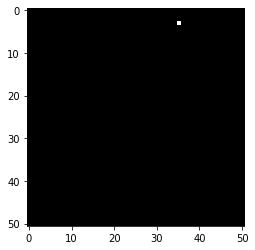

In [39]:
plt.imshow(grid)

In [39]:
def generate_mazes(n_rows=50, n_cols=50, n_mazes=10):
    m = maze.Maze()
    grids = []
    for i in tqdm(range(n_mazes)):
        m.create(n_rows, n_cols, maze.Maze.Create.PRIM)
        assert m.maze[1,1].mean()>128
        assert m.maze[-2,-2].mean()>128
        grids.append(m.maze)
    grids = np.stack(grids)
    grids = grids[:, :, :, 0]>128
    return grids

In [40]:
mazes = generate_mazes()

100%|██████████| 10/10 [00:00<00:00, 20.20it/s]


In [42]:
mazes.shape

(10, 101, 101)